# AML3104 - Neural Networks and Deep Learning
# Assignment #1
# Group Zero Budget

Team members:
- Aanal Patel - ID: 910376
- Danilo Diaz - ID: 889539
- Ernie Sumoso - ID: 881591
- Jay Saravanan - ID: 910392

## Table of Contents <a class="anchor" id="toc"></a>
* [Intro: Import Libraries](#intro-0)
* [Intro: Load Dataset](#intro-1)
* [Intro: Split Data](#intro-2)
* [Part I-a. Sampling happy and sad faces](#part-1a)
* [Part I-b. PCA and LDA to represent faces](#part-1b)
* [Part I-c. Naive Bayes classification](#part-1c)
* [Part I-d. Logistic Regression classification](#part-1d)
* [Part I-e. Support Vector Machine classification](#part-1e)
* [Part I-f. Question To Answer](#part-1f)
* [Part I-g. Showing 5 happiest and saddest faces](#part-1g)
* [Part II-a. Applying PCA and LDA and plotting cumulative variance of binary vs multiclass principal components](#part-2a)
* [Part II-b. Naive Bayes multiclass classification](#part-2b)
* [Part II-c. Logistic Regression multiclass classification](#part-2c)
* [Part II-d. Support Vector Machine multiclass classification](#part-2d)
* [Part II-e. Question To Answer](#part-2e)
* [Part II-f. Solution to identify mislabeled images](#part-2f)


### Intro: Import libraries <a class="anchor" id="intro-0"></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# You may need some sklearn specific imports, or other standard toolboxes

### Intro: Load dataset <a class="anchor" id="intro-1"></a>

In [4]:
trainingset = np.loadtxt('training.csv', delimiter=',')
testingset = np.loadtxt('test.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

### Intro: Split data <a class="anchor" id="intro-2"></a>

In [5]:
n_inputs = 2304 # images are 48 x 48
n_classes = 7 # 7 classes - as defined below
img_dim = 48 # each input image dimension, width and height are both 48

x_training = trainingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_training = trainingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_testing = testingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_testing = testingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_training = x_training.reshape(x_training.shape[0], 48, 48) # Make samples image shaped
x_testing = x_testing.reshape(x_testing.shape[0], 48, 48) # Make samples image shaped

In [6]:
def get_emotion(whichemotion):
    emotion_dict = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
    if whichemotion.shape[0] == 1:
        indx = whichemotion[0]
    else:
        indx = np.argmax(whichemotion)
    return emotion_dict[indx]

(28709, 48, 48)
(28709, 7)
(3589, 48, 48)
(3589, 7)


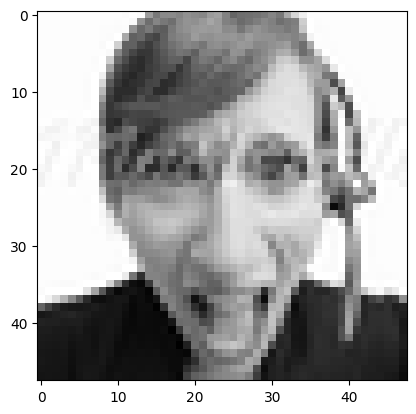

facial emotion: angry


In [7]:
print(x_training.shape)
print(y_training.shape)

print(x_testing.shape)
print(y_testing.shape)

sampleindex = np.random.randint(0,1000)
sample = x_training[sampleindex, :]
sample = sample.reshape(48, 48)

plt.imshow(sample, cmap='gray')
plt.show()
print('facial emotion: %s' % get_emotion(y_training[sampleindex, :]))

# Part I : Happy or Sad <a class="anchor" id="part-1a"></a>

## For this part you will consider a binary classification problem - categorizing faces as happy or sad

### Part I - a) Sampling happy and sad faces 

[1 Mark] a. Sample from the data loaded above to include only the happy or sad cases

In [8]:
import pandas as pd

def sample_dataset(x, y, emotions):
    # initialize sample subsets of the datasets passed as parameters
    sample_x = []
    sample_y = []

    # loop through the target values
    for i, y_instance in enumerate(y):

        # if the target value (emotion) is found within the list of emotions (parameter)
        emotion = get_emotion(y_instance)
        if emotion in emotions:

            # add the sample to the subset
            sample_x.append(list(x[i]))
            sample_y.append(emotions.index(emotion))

    # return nummpy arrays of the sample datasets (dependant and target variables)
    return np.array(sample_x), np.array(sample_y)

# sample dataset to include only happy or sad faces
sample_x_train, sample_y_train = sample_dataset(x_training, y_training, ['happy', 'sad'])
sample_x_test, sample_y_test = sample_dataset(x_testing, y_testing, ['happy', 'sad'])

In [9]:
# display: (number of happy or sad faces, image dimensions)
sample_x_train.shape

(12045, 48, 48)

### Part I - a) Commentary Section

We found __12,045__ total faces with happy or sad emotions.

The dimensions of each face image is __48 * 48__ pixels

[Return to the Table of Contents](#toc)

### Part I - b) PCA and LDA to represent faces <a class="anchor" id="part-1b"></a>

[4 Marks] b. Apply PCA and LDA to represent the faces, display a sample of a few faces for each case. You may consider using one or both of these in the steps that follow if they are of any value (this is for you to decide).

In [12]:
from sklearn.decomposition import PCA

def get_components_from_pca(x, y, n_components=0.8):
    # convert image pixel values (matrix) into an array
    x_fit = [face.flatten() for face in x]

    # fit a PCA with the array values
    pca = PCA(n_components=n_components)
    pca.fit(x_fit)

    # return only the PCA components
    return pca.components_, np.cumsum(pca.explained_variance_ratio_)

# get the PCA components from the happy/sad faces
pca_components, _ = get_components_from_pca(sample_x_train, sample_y_train)

# display: n° of components (31) and 2304 (48*48) pixel values
pca_components.shape

(31, 2304)

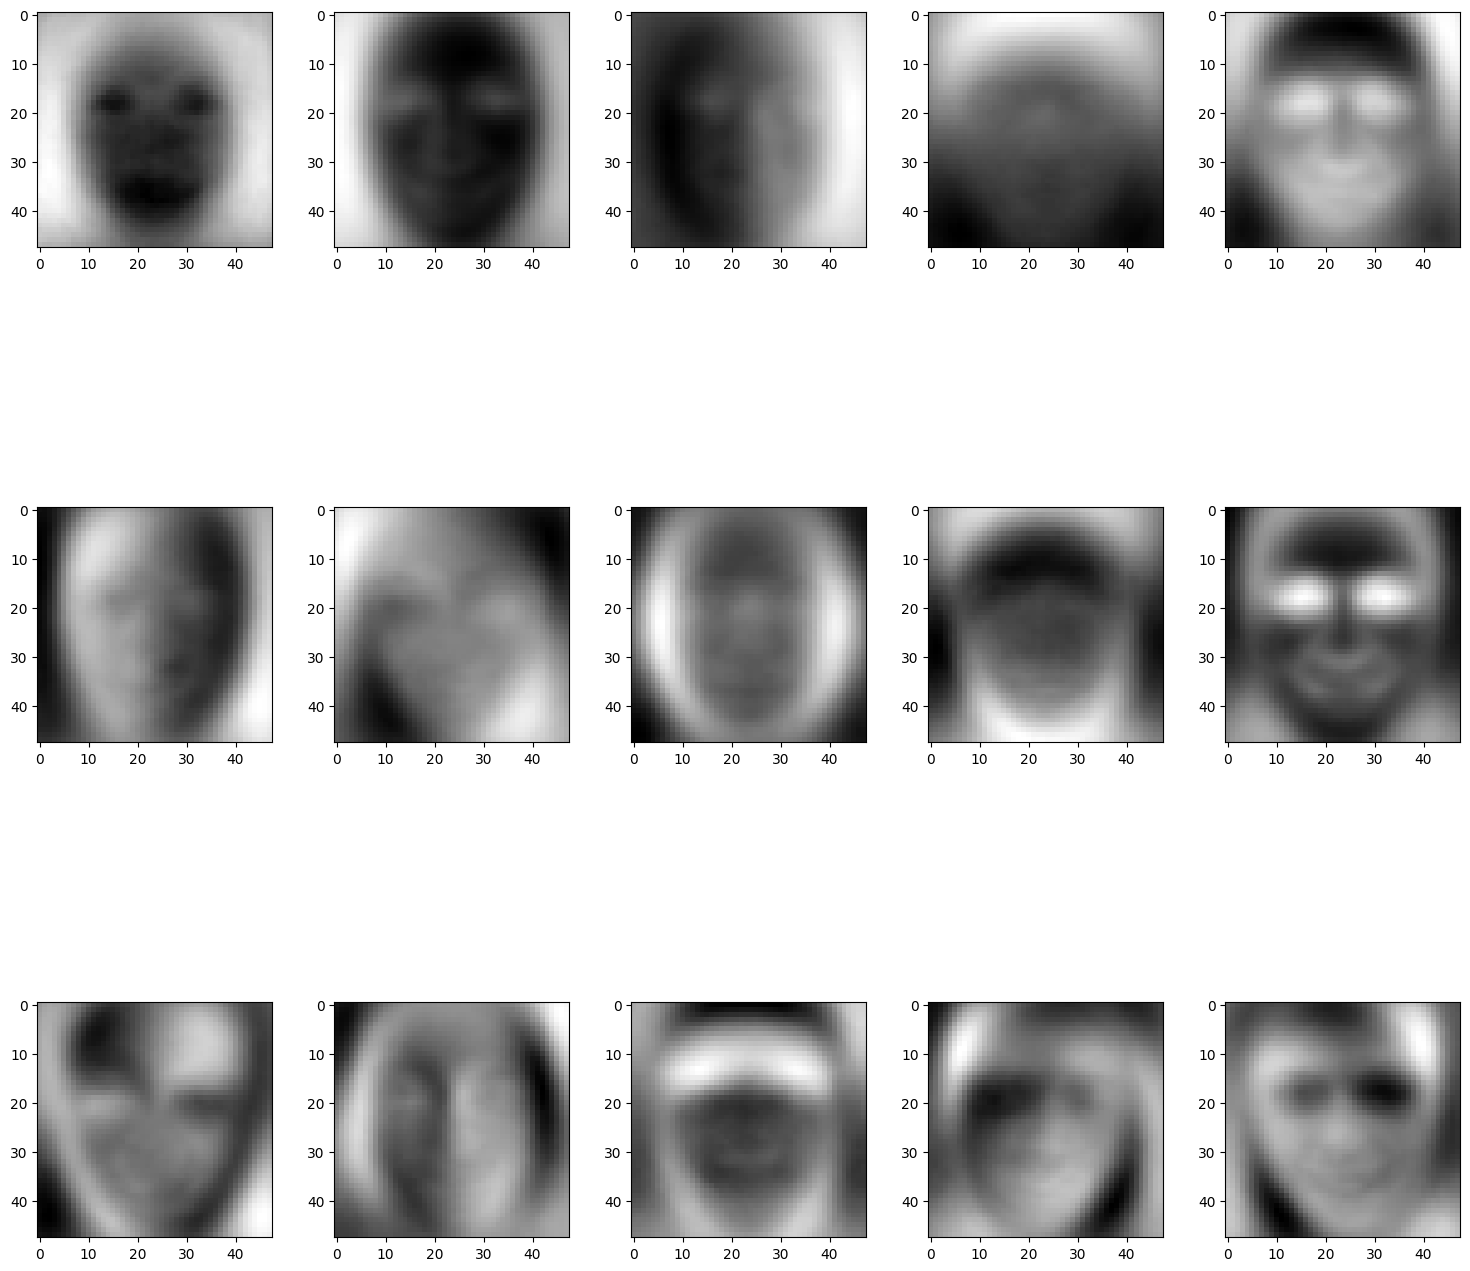

In [13]:
import math

def represent_face_using_pca(components, n_component, rows_cols, image_dimensions=(48, 48), cmap="gray"):
    
    # given the PCA components, display the image into the desired subplot
    plt.subplot(rows_cols[0], rows_cols[1], n_component+1)
    plt.imshow(components[n_component].reshape(image_dimensions), cmap=cmap)

def represent_x_faces_using_pca(components, x, image_dimensions=(48, 48), cmap="gray", faces_per_row=5, subplots_size=(15,15)):

    # set the row and column of the subplot to be drawn
    cols = min(x, faces_per_row)
    rows = math.ceil(x / faces_per_row)

    # set the layout of the subplots
    fig, axs = plt.subplots(rows, cols, figsize=subplots_size)
    fig.tight_layout()

    # representing X number of different faces using PCA on each subplot
    for i in range(x):
        represent_face_using_pca(components, i, rows_cols=(rows, cols), image_dimensions=image_dimensions, cmap=cmap)
    plt.show()

# show 15 faces using the PCA components
represent_x_faces_using_pca(pca_components, x = 15)

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def get_components_from_lda(x, y, n_components=0.8):

    # apply PCA on our dataset first before proceeding to LDA
    pca = PCA(n_components=n_components)
    x_fit = [x_instance.flatten() for x_instance in x]
    x_pca = pca.fit_transform(x_fit)

    # apply LDA on top of the PCA components, use eigen solver (Eigenvalue decomposition)
    # so that we are able to represent the face
    lda = LDA(solver='eigen')
    x_lda = lda.fit_transform(x_pca, y)

    # return the PCA model and LDA components
    lda_components = lda.scalings_.T
    return pca, lda_components

# get LDA components
pca, lda_components = get_components_from_lda(sample_x_train, sample_y_train)
lda_components.shape

(31, 31)

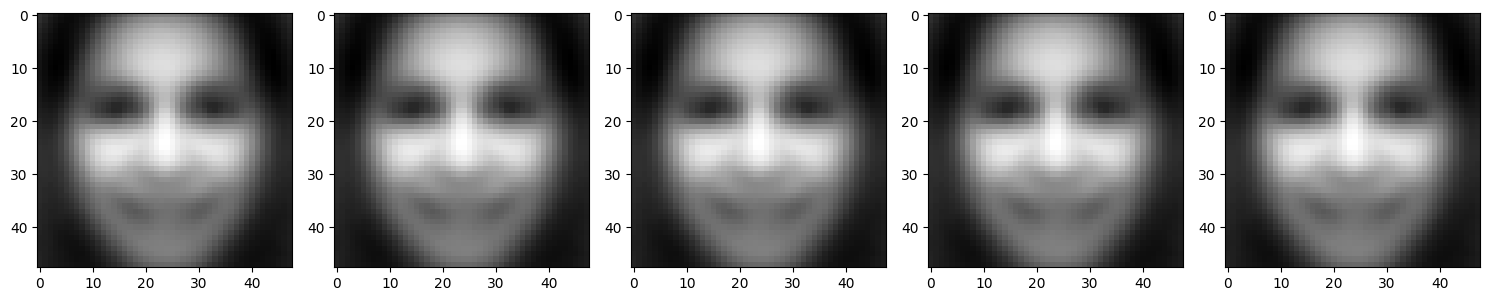

In [15]:
def represent_face_using_lda(faces, n_face, rows_cols, image_dimensions=(48, 48), cmap="gray"):
    
    # given the LDA components, display the image into the desired subplot
    plt.subplot(rows_cols[0], rows_cols[1], n_face+1)
    plt.imshow(faces[n_face].reshape(image_dimensions), cmap=cmap)

def represent_x_faces_using_lda(faces, x, image_dimensions=(48, 48), cmap="gray", faces_per_row=5, subplots_size=(15,15)):

    # set the row and column of the subplot to be drawn
    cols = min(x, faces_per_row)
    rows = math.ceil(x / faces_per_row)
    
    # set the layout of the subplots
    fig, axs = plt.subplots(rows, cols, figsize=subplots_size)
    
    # represent X number of different faces using LDA on each subplot
    for i in range(x):
        represent_face_using_lda(faces, i, rows_cols=(rows, cols), image_dimensions=image_dimensions, cmap=cmap)
    
    fig.tight_layout()
    plt.show()

# represent 5 faces using LDA
faces = pca.inverse_transform(lda_components)
represent_x_faces_using_lda(faces, x = 5)

### Part I - b) Commentary Section

We successfully __applied PCA__ on our happy/sad faces dataset and __plotted 15 PCA representations__.

We also __applied LDA on 5 faces__. However, LDA results were not significantly visible when plotting the representions.

[Return to the Table of Contents](#toc)

### Part I - c) Naive Bayes classification <a class="anchor" id="part-1c"></a>

[2 Marks] c. Apply naive Bayes to classify faces as happy or sad. Report your accuracy.

In [16]:
def flatten_image_dataset(dataset):

    # convert an image dataset into a single dimension per image (flatten images into an array)
    return np.array([list(instance.flatten()) for instance in dataset])

# flatten all subsets to process them later
flat_x_train = flatten_image_dataset(sample_x_train)
flat_y_train = flatten_image_dataset(sample_y_train).ravel()
flat_x_test = flatten_image_dataset(sample_x_test)
flat_y_test = flatten_image_dataset(sample_y_test).ravel()
flat_x_test.shape

(1548, 2304)

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score

# function to train a model
def train_model(model, x_train, y_train, x_test):
    model_fitted = model.fit(x_train, y_train)
    display(model_fitted)
    y_pred_train = model_fitted.predict(x_train)
    y_pred_test = model_fitted.predict(x_test)
    return y_pred_train, y_pred_test

# function to display the classification model metrics
def display_classifier_metrics(y_train, y_pred_train, y_test, y_pred_test, average='binary'):
    print(f"Acuracy Score - Train Subset: {accuracy_score(y_train, y_pred_train)*100:.2f}%")
    print(f"Acuracy Score - Test Subset: {accuracy_score(y_test, y_pred_test)*100:.2f}%")
    print(f"F1 Score - Train Subset: {f1_score(y_train, y_pred_train, average=average):.4f}")
    print(f"F1 Score - Test Subset: {f1_score(y_test, y_pred_test, average=average):.4f}", end='\n\n')

# use Naive Bayes to classify sad and happy faces
gnb = GaussianNB()
y_pred_train, y_pred_test = train_model(gnb, flat_x_train, flat_y_train, flat_x_test)
display_classifier_metrics(flat_y_train, y_pred_train, flat_y_test, y_pred_test)

GaussianNB()

Acuracy Score - Train Subset: 60.12%
Acuracy Score - Test Subset: 59.04%
F1 Score - Train Subset: 0.5095
F1 Score - Test Subset: 0.5123



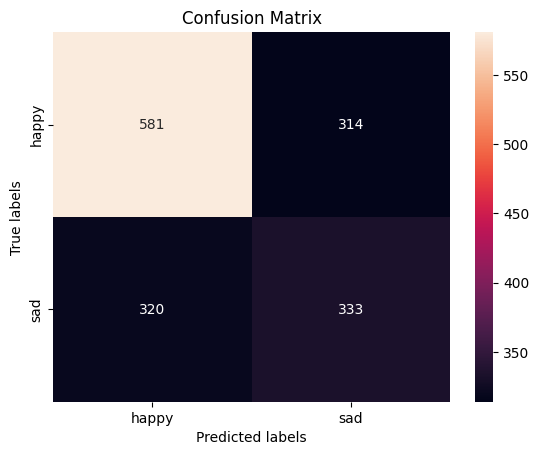

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# function to plot a confusion matrix based on prediction results
def plot_confusion_matrix(y_test, y_pred_test, labels=[]):
    # set the confusion matrix
    matrix = confusion_matrix(y_test, y_pred_test)
    df = pd.DataFrame(matrix, columns=labels)
    df.index = labels
    
    # plot the heatmap and set labels
    sns.heatmap(df, annot=True, fmt="d")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(flat_y_test, y_pred_test, labels=['happy', 'sad'])

### Part I - c) Commentary Section

After __applying Naive Bayes classification__ on the happy/sad faces, we get an aproximate __60% accuracy__ on the predictions.

The __confusion matrix__ shows how our model can predict most happy faces but is mostly __struggling to classify sad faces__.

Both training and test accuracies are low, which indicates an __underfitted__ machine learning model.

[Return to the Table of Contents](#toc)

### Part I - d) Logistic Regression classification <a class="anchor" id="part-1d"></a>

[2 Marks] d. Apply Logistic regression to classify faces as happy or sad. Report the accuracy.

LogisticRegression()

Acuracy Score - Train Subset: 74.26%
Acuracy Score - Test Subset: 69.44%
F1 Score - Train Subset: 0.6489
F1 Score - Test Subset: 0.5919



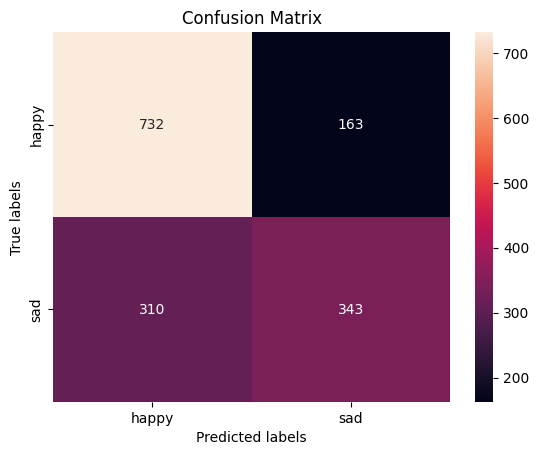

In [76]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

# use LogisticRegression to classify sad and happy faces
lr = LogisticRegression()
y_pred_train, y_pred_test = train_model(lr, flat_x_train, flat_y_train, flat_x_test)
display_classifier_metrics(flat_y_train, y_pred_train, flat_y_test, y_pred_test)
plot_confusion_matrix(flat_y_test, y_pred_test, labels=['happy', 'sad'])

### Part I - d) Commentary Section

When using __Logistic Regression__ to classify on the happy/sad faces, we get an aproximate __70% accuracy__ on the predictions.

This is a much more improvement from the previous Naive Bayes algorithm.

The __confusion matrix__ shows that our model still __struggles to classify sad faces__ correctly.

There is a __5% difference__ between training and testing accuracy, indicating an __slightly overfitted__ machine learning model.

[Return to the Table of Contents](#toc)

### Part I - e) Support Vector Machine classification <a class="anchor" id="part-1e"></a>

[2 Marks] e. Apply a Support Vector Machine to classify the faces as happy or sad. Choose parameters / arguments to try to maximize your accuracy. Report the accuracy.

SVC()

Acuracy Score - Train Subset: 86.10%
Acuracy Score - Test Subset: 73.58%
F1 Score - Train Subset: 0.8174
F1 Score - Test Subset: 0.6617



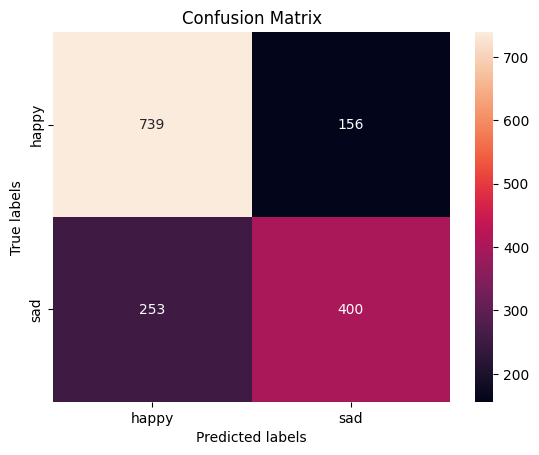

In [77]:
from sklearn.svm import SVC

# use Support Vector Machine to classify sad and happy faces
svm = SVC()
y_pred_train, y_pred_test = train_model(svm, flat_x_train, flat_y_train, flat_x_test)
display_classifier_metrics(flat_y_train, y_pred_train, flat_y_test, y_pred_test)
plot_confusion_matrix(flat_y_test, y_pred_test, labels=['happy', 'sad'])

In [ ]:
from sklearn.model_selection import GridSearchCV

def hyperparameter_tuning(model, param_grid, x_train, x_test, y_train, y_test):
    # instantiate grid search cross validation and fit it with training data
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(x_train, y_train)
 
    # print best hyperparameters and accuracy score found
    model_name = type(model).__name__ # extract the model name
    print("Model:", model_name)
    print("Best Hyperparameters: ", grid_search.best_params_)
    print("Best Accuracy Score: {:.2f} %".format(grid_search.best_score_ * 100))
    best_model = grid_search.best_estimator_
    test_accuracy = best_model.score(x_test, y_test)
    print("Test Accuracy Score: {:.2f} %".format(test_accuracy * 100))
    
    # return the best model
    return best_model

# define grid search
param_grid = {"C": [10, 1, 0.1], "kernel": ['rbf', 'sigmoid']}
svm = SVC()
best_svm = hyperparameter_tuning(svm, param_grid, flat_x_train, flat_x_test, flat_y_train, flat_y_test)
best_svm

### Part I - e) Commentary Section

The __Support Vector Machine__ model presents the __best accuracy score__ for both test and train subsets.

We used __GridSearch Cross Validation__ for __hyperparameter tuning__.

The resulting __best parameters__ are:

- C = 10 (determines how many data samples are allowed to be placed in different classes)
- Kernel = rbf (Radial Basis Function)

There is a __< 1% difference__ between test and train accuracies, which demonstrates that our model is __NOT overfitted nor underfitted__.

[Return to the Table of Contents](#toc)

### Part I - f) Question To Answer <a class="anchor" id="part-1f"></a>

[1 Mark] f. Which of the approaches above allow you to reliably determine the degree of happiness or sadness (i.e. how happy or how sad)? Which do you trust the most?

### Part I - f) Answer

Using __Support Vector Machine__ (SVM) shows a more __reliable classification__ of happy and sad faces due to its model accuracy achieved and F1 score.
- Train Accuracy Score: 75.19 %
- Test Accuracy Score: 74.81 %

__SVM__ works best on classifying our dataset because of __2 reasons__:
- It creates a clear __margin of separation between 2 classes__
- SVM is more __effective in high dimensional spaces__. In this case we are using image resolution as features, which creates 2,304 features, hence a high dimensional space.

[Return to the Table of Contents](#toc)

### Part I - g) Showing 5 happiest and saddest faces <a class="anchor" id="part-1g"></a>

[2 Marks] g. Based on your answer to f. show the 5 happiest faces and the 5 saddest faces.

In [ ]:
def get_top_n_faces(n, x_test, y_test, class_num, image_dimensions=(48,48), cmap='gray'):
    # get the decision scores from our best SVM model using the test subset
    decision_scores = best_svm.decision_function(x_test)

    # get the class indexes and scores from the test subset
    class_indexes = np.where(y_test == class_num)[0]
    class_scores = decision_scores[class_indexes]

    # using argpartition (numpy method) get the top N faces with the highest decision scores for the given class
    top_n_faces = np.argpartition(class_scores, -n)[-n:]
    top_n_faces_indexes = class_indexes[top_n_faces]

    # set the layout of the subplots
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    
    # display the top N faces for the given class
    for i, index in enumerate(top_n_faces_indexes):
        plt.subplot(1, n, i+1)
        plt.imshow(x_test[index].reshape(image_dimensions), cmap=cmap)
    
    fig.tight_layout()
    plt.show()

In [ ]:
# show the 5 happiest faces
get_top_n_faces(5, flat_x_test, flat_y_test, 0)

In [ ]:
# show the 5 saddest faces
get_top_n_faces(5, flat_x_test, flat_y_test, 1)

### Part I - g) Commentary Section

We were able to __show the happiest and saddest faces__ (5 of each) by measuring the SVM classification on each instance.

To __measure the classifications__ we used the decision function method, which gives us the __decision scores__.

[Return to the Table of Contents](#toc)

# Part II : Multi-class

## For this part you will repeat the tasks in Part I, but instead consider the multi-class problem and classify inputs according to all 7 classes. 

### Part II - a) Applying PCA and LDA and plotting cumulative variance of binary vs multiclass principal components <a class="anchor" id="part-2a"></a>

[4 Marks] a. Apply PCA and LDA to represent the faces, display a sample of a few faces for each case. Produce a plot for PCA showing the cumulative variance captured by adding additional principal components (e.g. 1st PC, 1st + 2nd PC, etc.). On the same figure, plot the same curve for only happy and sad faces used in part 1.

In [74]:
# sample dataset to include only happy or sad faces
binary_x_train, binary_y_train = sample_dataset(x_training, y_training, ['happy', 'sad'])
binary_x_test, binary_y_test = sample_dataset(x_testing, y_testing, ['happy', 'sad'])

# sample dataset using all emotions, just to convert 7 target features into 1 unique target feature with 7 classes
ALL_EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
multi_x_train, multi_y_train = sample_dataset(x_training, y_training, ALL_EMOTIONS)
multi_x_test, multi_y_test = sample_dataset(x_testing, y_testing, ALL_EMOTIONS)

# display: (number of happy or sad faces, image dimensions)
display(binary_x_train.shape)

# display: (number of total faces for multiclass, image dimensions)
display(multi_x_train.shape)

(12045, 48, 48)

(28709, 48, 48)

In [61]:
# get the PCA components from the happy/sad faces
pca_components_binary, commulative_variance_binary = get_components_from_pca(binary_x_train, binary_y_train)

In [62]:
# get the PCA components from the multiple classes
pca_components_multi, commulative_variance_multi = get_components_from_pca(multi_x_train, multi_y_train, n_components=0.95)

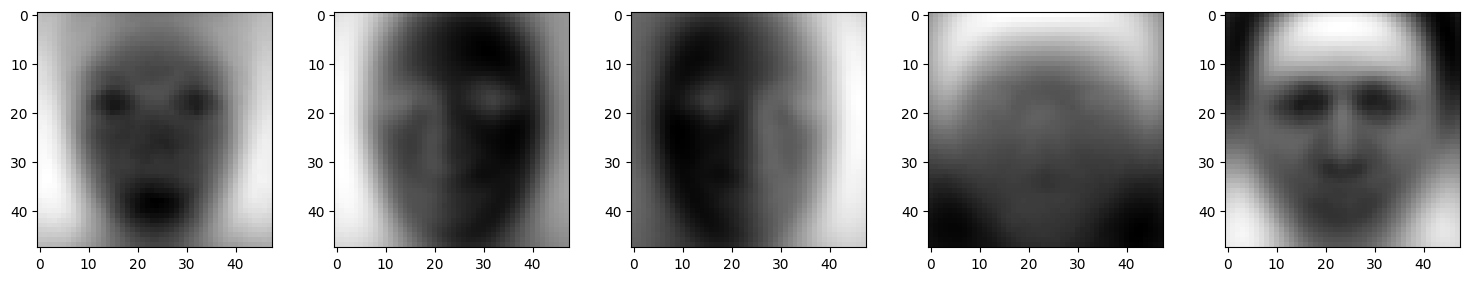

In [63]:
# represent 5 faces using PCA components using the multi-class dataset
represent_x_faces_using_pca(pca_components_multi, x = 5)

In [65]:
# apply LDA on the multi-class dataset
pca_multi, lda_components_multi = get_components_from_lda(multi_x_train, multi_y_train)
lda_components_multi.shape

(32, 32)

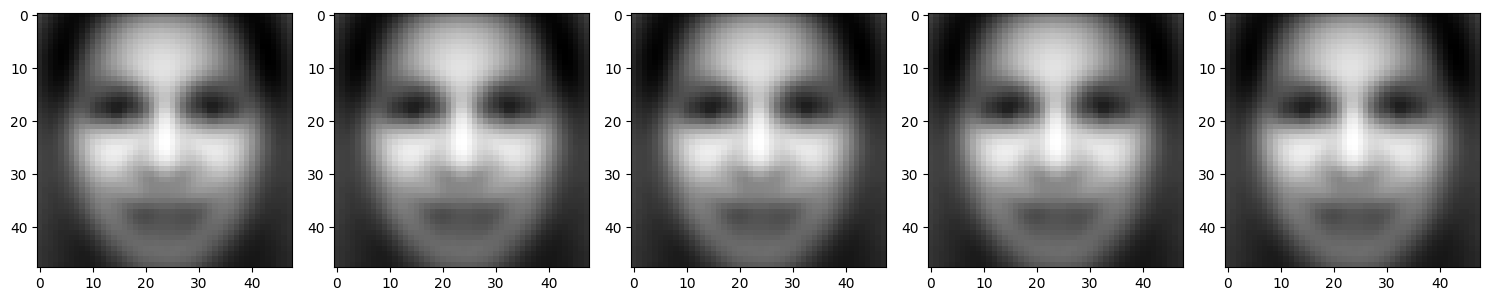

In [67]:
# represent 5 faces using LDA components using the multi-class dataset
faces_multi= pca_multi.inverse_transform(lda_components_multi)
represent_x_faces_using_lda(faces_multi, x = 5)

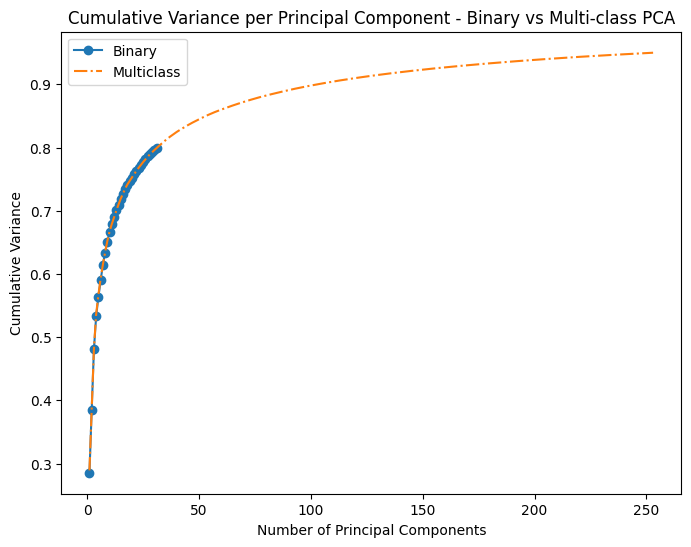

In [68]:
# plot cumulative variance of the PCA components of binary vs multiclass classification
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, len(commulative_variance_binary) + 1), commulative_variance_binary, label= 'Binary class', marker='o')
plt.plot(np.arange(1, len(commulative_variance_multi) + 1), commulative_variance_multi, label= 'Multi class', linestyle='-.')
plt.title('Cumulative Variance per Principal Component - Binary vs Multi-class PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance')
plt.legend(['Binary', 'Multiclass'])
plt.show()

### Part II - a) Commentary Section

[Return to the Table of Contents](#toc)

### Part II - b) Naive Bayes multiclass classification <a class="anchor" id="part-2b"></a>

[2 Marks] b. Classify the faces using Naive Bayes and report your accuracy.

In [73]:
# flatten all subsets to process them later
flat_multi_x_train = flatten_image_dataset(x_training)
flat_multi_y_train = flatten_image_dataset(y_training).ravel()
flat_multi_x_test = flatten_image_dataset(x_testing)
flat_multi_y_test = flatten_image_dataset(y_testing).ravel()
flat_multi_x_train.shape

(28709, 2304)

In [92]:
np.unique(flat_multi_y_train)

array([0., 1.])

In [103]:
encoded = []
for i, instance in enumerate(y_training):
    encoded.append(list(instance).index(1))
encoded = np.array(encoded)

In [108]:
encoded_test = []
for i, instance in enumerate(y_testing):
    encoded_test.append(list(instance).index(1))
encoded_test = np.array(encoded_test)

In [104]:
# use Naive Bayes to classify 7 classes of emotions
gnb_multi = GaussianNB()
y_multi_pred_train, y_multi_pred_test = train_model(gnb_multi, flat_multi_x_train, encoded, flat_multi_x_test)

GaussianNB()

Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.
DESCRIBE BRIEFLY HERE

In [109]:
display_classifier_metrics(encoded, y_multi_pred_train, encoded_test, y_multi_pred_test, average='weighted')

Acuracy Score - Train Subset: 22.24%
Acuracy Score - Test Subset: 22.74%
F1 Score - Train Subset: 0.2041
F1 Score - Test Subset: 0.2069



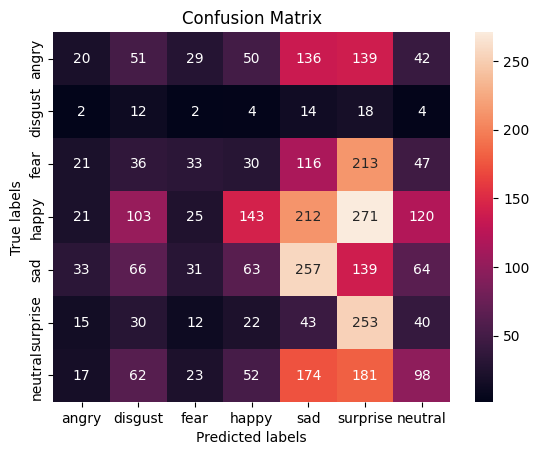

In [110]:
plot_confusion_matrix(encoded_test, y_multi_pred_test, labels=['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'])

## Confusion Matrix Overview  

| True \ Predicted | Angry | Disgust | Fear | Happy | Sad | Surprise | Neutral |  
|------------------|-------|---------|------|-------|-----|----------|---------|  
| **Angry**        | 20    | 51      | 29   | 50    | 136 | 139      | 42      |  
| **Disgust**      | 2     | 12      | 4    | 14    | 18  | 4        | 0       |  
| **Fear**         | 21    | 36      | 33   | 30    | 116 | 213      | 47      |  
| **Happy**        | 21    | 103     | 25   | 143   | 212 | 271      | 120     |  
| **Sad**          | 33    | 66      | 31   | 63    | 257 | 139      | 64      |  
| **Neutral**      | 15    | 30      | 12   | 22    | 43  | 253      | 40      |  
| **Surprise**     | 17    | 62      | 23   | 52    | 174 | 181      | 98      |  


## Interpretation  

- **Diagonal Values**: The values along the diagonal (e.g., 20 for Angry, 12 for Disgust, ..., 98 for surprise) represent the number of correct predictions (True positives) for each class. Higher values indicate better performance for that class.  

- **Off-Diagonal Values**: These values indicate misclassifications (False Negatives). For example, the model predicted "Angry" when the true label was "Happy" 136 times, suggesting confusion between these two emotions.  

- **Class Imbalance**: The matrix shows that some classes, like "Happy" and "Sad," have significantly more instances than others, which may affect the model's performance.  

### Part II - c) Logistic Regression multiclass classification <a class="anchor" id="part-2c"></a>

[2 Marks] c. Classify the faces using logistic regression and report your accuracy.

In [111]:
# use LogisticRegression to classify multiple classes
lr_multi = LogisticRegression(multi_class='multinomial', solver='lbfgs')
y_multi_pred_train, y_multi_pred_test = train_model(lr_multi, flat_multi_x_train, encoded, flat_multi_x_test)

LogisticRegression(multi_class='multinomial')

Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.
DESCRIBE BRIEFLY HERE

Acuracy Score - Train Subset: 38.39%
Acuracy Score - Test Subset: 37.09%
F1 Score - Train Subset: 0.3555
F1 Score - Test Subset: 0.3405



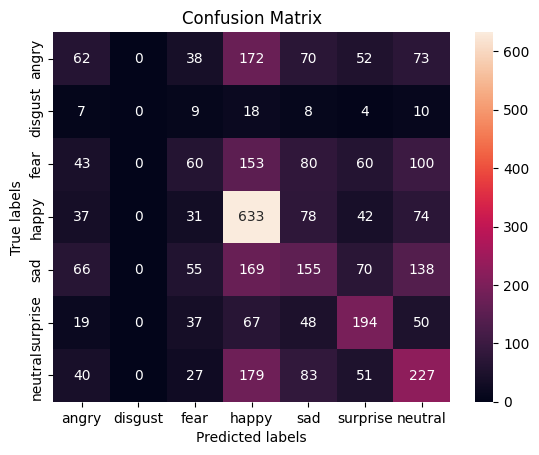

In [113]:
display_classifier_metrics(encoded, y_multi_pred_train, encoded_test, y_multi_pred_test, average='weighted')
plot_confusion_matrix(encoded_test, y_multi_pred_test, labels=ALL_EMOTIONS)

### Part II - d) Support Vector Machine multiclass classification <a class="anchor" id="part-2d"></a>

[2 Marks] d. Classify the faces using a support vector machine and report your accuracy.

In [ ]:
svm_multi = SVC()
y_multi_pred_train, y_multi_pred_test = train_model(svm_multi, flat_multi_x_train, flat_multi_y_train, flat_multi_x_test)
display_classifier_metrics(flat_multi_y_train, y_multi_pred_train, flat_multi_y_test, y_multi_pred_test, average='weighted')
plot_confusion_matrix(flat_multi_y_test, y_multi_pred_test, labels=['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'])

Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.
DESCRIBE BRIEFLY HERE

### Part II - e) Question To Answer <a class="anchor" id="part-2e"></a>

[2 Marks] e. Which categories of faces seem to be most similar or least similar?
EXPLAIN HERE

### Part II - f) Solution to identify mislabeled images <a class="anchor" id="part-2f"></a>

[4 Marks] f. Let's assume that some of the faces were labeled wrong in producing the dataset. Propose and implement a solution that identifies images that are potentially mislabeled. Show 10 samples based on the method you choose.

In [ ]:
# Train the Logistic Regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(flat_multi_x_train, flat_multi_y_train)

# Predict on the test data
predictions_lr = model.predict(flat_multi_x_test)
confidence_scores_lr = model.predict_proba(flat_multi_x_test)

# Set a threshold for confidence
threshold = 0.6

# Identify potentially mislabeled images
mislabeled = []
for i in range(len(predictions_lr)):
    if max(confidence_scores_lr[i]) < threshold and predictions_lr[i] != flat_multi_y_test[i]:
        mislabeled.append(i)

# Randomly select 10 samples from the potentially mislabeled images
if len(mislabeled) >= 10:  
    sample = np.random.choice(mislabeled, size=10, replace=False)

    # Display the selected samples
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(sample):
        plt.subplot(2, 5, i + 1)
        plt.imshow(flat_multi_x_test[idx].reshape(48, 48), cmap='gray') 
        plt.title(f'Predicted: {predictions_lr[idx]}, Actual: {flat_multi_y_test[idx]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough mislabeled samples found.")


## Identifying Potentially Mislabeled Images using Logistic Regression and Confidence Scores

### Overview
This approach uses **Logistic Regression** to predict labels for a multiclass dataset and identifies potentially mislabeled images based on the model’s confidence in its predictions. Images where the model has **low confidence** (below a defined threshold<0.6) and makes a wrong prediction are flagged as potentially mislabeled.

### Steps:
1. **Train the Logistic Regression Model**: 
   - The model is trained on the flattened images (`flat_multi_x_train`) and corresponding labels (`y_train`).
   
2. **Predict and Obtain Confidence Scores**: 
   - We predict the test labels using `model.predict` and obtain the confidence scores for each prediction using `model.predict_proba`.

3. **Set a Confidence Threshold**:
   - We set a threshold of 0.6. If the model’s confidence in a prediction is less than 60%, and the prediction is incorrect (i.e., doesn’t match the true label), we flag the image as potentially mislabeled.

4. **Select and Display Samples**:
   - We randomly select 10 images from the set of potentially mislabeled images and display them for visual inspection, showing both the predicted and actual labels.

### Benefits:
- This method allows us to automatically detect and review images that the model is uncertain about, potentially identifying errors in the dataset's labeling.


# Optional

From all the classification approaches considered above, choose one to score faces based on a continuous valued prediction of for each of the categories.

[No Marks] a. Produce a prediction for each face in the test set (this has 7 dimensions). Visualize these based on a 2D embedding of the scores. The "data points" plotted in the embedding should show the actual picture of the face, at the corresponding 2D point location. (You could consider using t-SNE for your embedding)

In [ ]:
# YOUR CODE HERE